## Class imbalance and depletion estimates from experimental data 

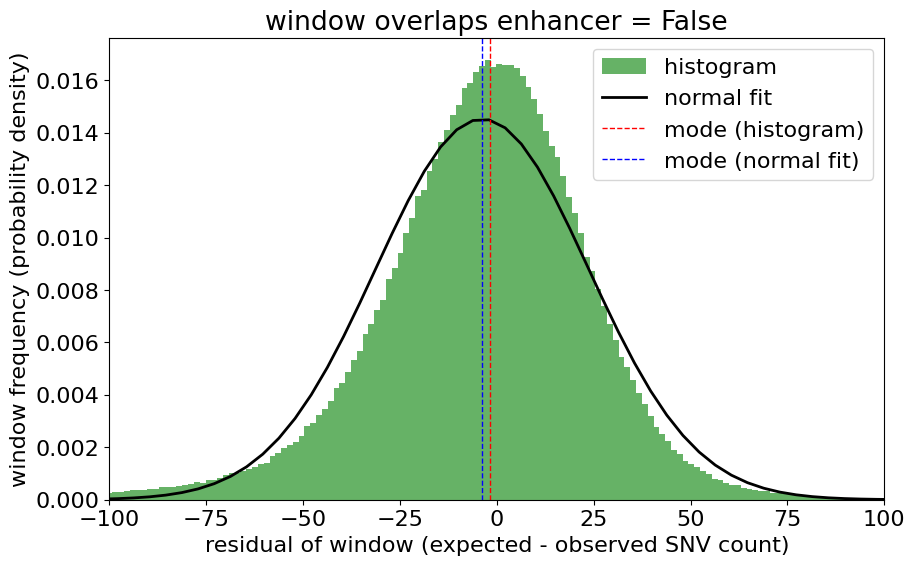

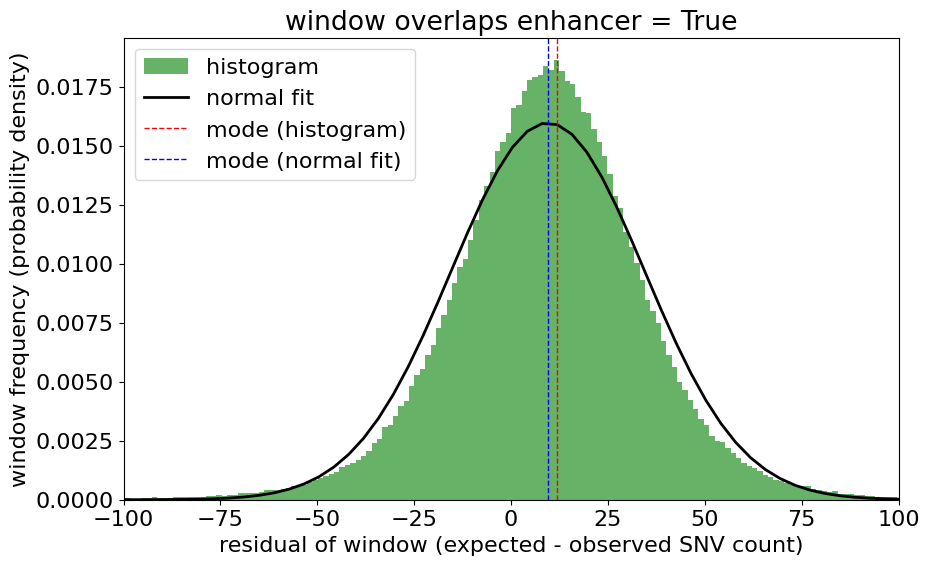

(   window overlaps enhancer   count
 0                     False  693270
 1                      True  309957,
    depletion_histogram  depletion_fit
 0            13.676763      13.293118)

In [1]:
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-labs/quinlan/data-shared/constraint-tools'

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm

plt.rcParams.update({'font.size': 16})

def get_noncoding_chen_windows(): 
    df = pl.read_csv(
        # non-exonic windows
        f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2.features.constraint_scores.bed', 
        separator='\t',
    )
    df = df.to_pandas()
    return df 

def compute_number_records_in_each_class(df):
    ser = df['window overlaps enhancer'].value_counts()
    df = ser.to_frame().reset_index()
    df.columns = ['window overlaps enhancer', 'count']
    return df

def plot_residual_distribution_experiment(df, window_overlaps_enhancer): 
    df_subset = df[df['window overlaps enhancer'] == window_overlaps_enhancer]

    # Compute histogram
    counts, bin_edges = np.histogram(df_subset['residual'], bins=1000)
    
    # Find the bin with the maximum count
    max_bin_index = np.argmax(counts)
    mode_histogram = (bin_edges[max_bin_index] + bin_edges[max_bin_index + 1]) / 2
    
    # Fit a normal distribution to the data
    mu, std = norm.fit(df_subset['residual'])
    
    # Compute the mode of the normal distribution
    mode_fit = mu  # For a normal distribution, the mode is the same as the mean

    plt.figure(figsize=(10, 6))

    # Plot histogram
    plt.hist(df_subset['residual'], bins=250, density=True, alpha=0.6, color='g', label='histogram')
    
    # Plot the normal distribution
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100) 
    p = norm.pdf(x, mu, std) 
    plt.plot(x, p, 'k', linewidth=2, label='normal fit')
    
    # Plot vertical lines
    plt.axvline(mode_histogram, color='r', linestyle='dashed', linewidth=1, label='mode (histogram)')
    plt.axvline(mode_fit, color='b', linestyle='dashed', linewidth=1, label='mode (normal fit)')
    
    plt.title(f'window overlaps enhancer = {window_overlaps_enhancer}')
    plt.xlabel('residual of window (expected - observed SNV count)')
    plt.ylabel('window frequency (probability density)')

    plt.xlim(-100, 100)

    plt.legend()
    plt.show()

    return mode_histogram, mode_fit

def compute_depletion(df):
    df = pd.DataFrame({ 
        'window overlaps enhancer': df['window overlaps enhancer'],
        'residual': df['N_mean_null_gnocchi'] - df['N_observed'],
    })

    mode_histogram_unconstrained, mode_fit_unconstrained = plot_residual_distribution_experiment(df, window_overlaps_enhancer=False)
    mode_histogram_constrained, mode_fit_constrained = plot_residual_distribution_experiment(df, window_overlaps_enhancer=True)

    depletion_histogram = mode_histogram_constrained - mode_histogram_unconstrained
    depletion_fit = mode_fit_constrained - mode_fit_unconstrained

    depletion = pd.DataFrame({
        'depletion_histogram': [depletion_histogram],
        'depletion_fit': [depletion_fit],
    })

    return depletion
    
def compute_class_imbalance_and_depletion():
    df = get_noncoding_chen_windows()  
    number_records_in_each_class = compute_number_records_in_each_class(df)  
    depletion = compute_depletion(df)
    return number_records_in_each_class, depletion

compute_class_imbalance_and_depletion()

In light of these experimental results, 
we will use a class imbalance of 7:3 (unconstrained:constrained) and a depletion of SNV counts due to (weak) purifying selection of about 15 in simulations, which we turn to next. 

## Sample from a feature distribution (mimicking GC content, the length of a genomic interval, etc)

Text(0, 0.5, 'number of examples')

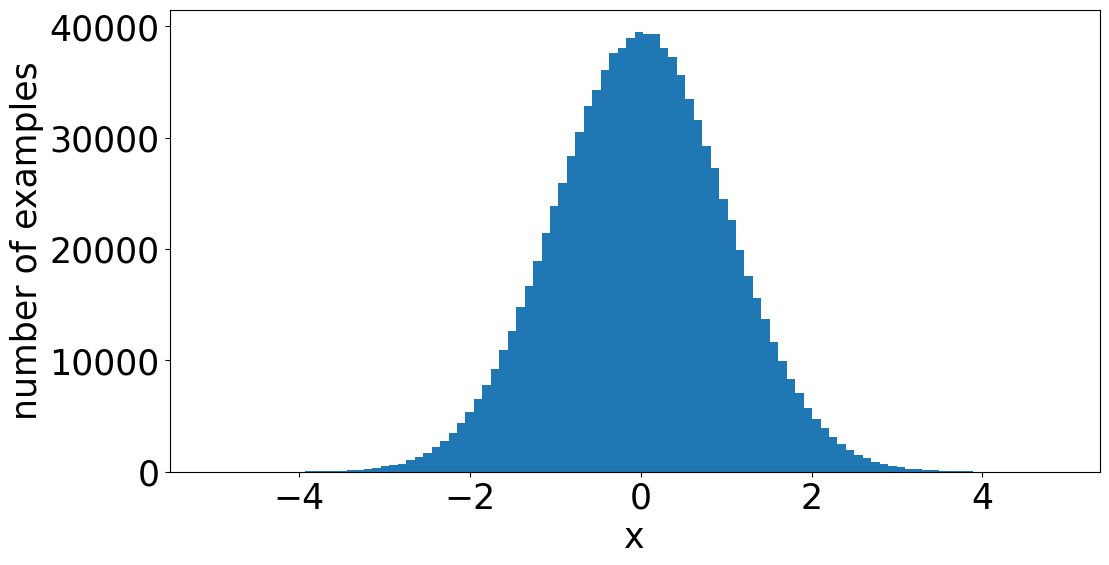

In [20]:
plt.rcParams.update({'font.size': 25})

NUMBER_EXAMPLES = 1000000 # Number of intervals

# Sample from a univariate normal distribution
MEAN = 0
STD = 1
xs = np.random.normal(loc=MEAN, scale=STD, size=NUMBER_EXAMPLES)

plt.figure(figsize=(12, 6))
plt.hist(xs, bins=100)
plt.xlabel('x')
plt.ylabel('number of examples')

## True mapping from feature to target (mimicking SNV counts)

(0.0, 400.0)

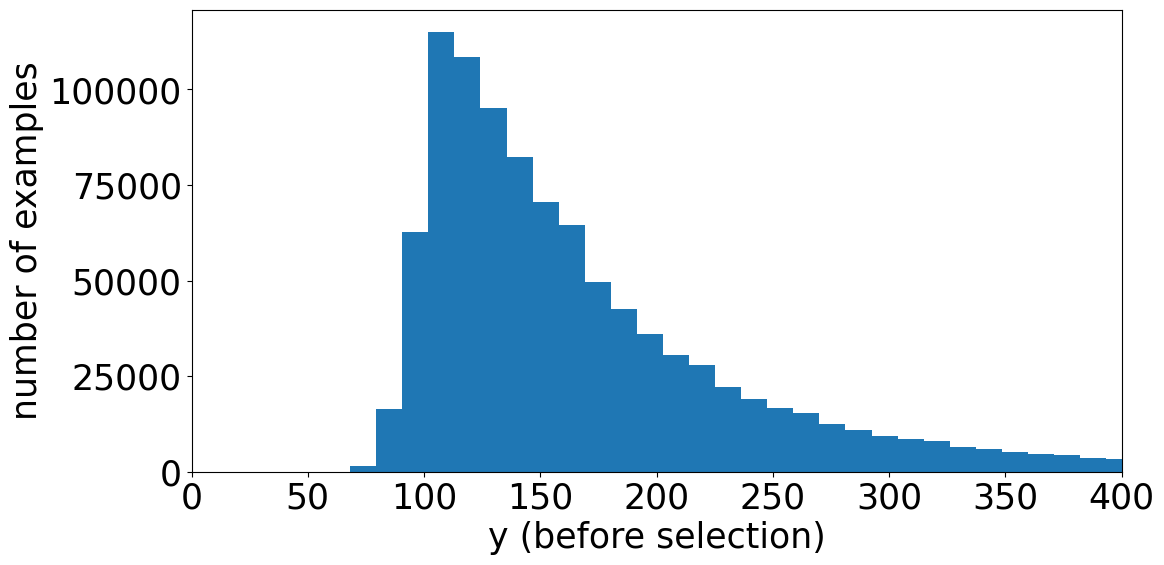

In [21]:
# parameters of true model 
A = 5
B = 0.4
C = 0.1

TRUE_PARAMS_KEYS = ['A', 'B', 'C']
TRUE_PARAMS_VALUES = [A, B, C]

TRUE_RATE = lambda x: np.exp(A + B*x + C*x**2) # rate function

ys = np.random.poisson(lam=TRUE_RATE(xs)) # target 

plt.figure(figsize=(12, 6))
plt.hist(ys, bins=1000)
plt.xlabel('y (before selection)')
plt.ylabel('number of examples')
plt.xlim(0, 400)

## Introduce selection into a small fraction of examples

In [22]:
# Declare some of the examples to be positive examples, and reduce their y values, 
# to mimic the effect of negative selection 

# Declare the remaining examples to be neutral (negative) examples, and do not change their y values

POSITIVE_FRACTION = 0.3 # informed by experiment

num_pos = int(POSITIVE_FRACTION*NUMBER_EXAMPLES)

# FRACTIONAL_REDUCTION_IN_Y = 0.2
# x_factor = (xs - xs.min()) / (xs.max() - xs.min())
# y_pos = ys[:num_pos] * (1 - FRACTIONAL_REDUCTION_IN_Y * x_factor[:num_pos])

Y_DEPLETION = 15 # informed by experiment
y_pos = np.maximum(0, ys[:num_pos] - Y_DEPLETION)

y_neg = ys[num_pos:]
ys = np.concatenate([y_pos, y_neg])

constrained = num_pos*[True] + (NUMBER_EXAMPLES-num_pos)*[False]

DATA = pd.DataFrame({'x': xs, 'y': ys, 'constrained': constrained})
DATA

,x,y,constrained
0,0.717529,206,True
1,-1.076697,96,True
2,0.687623,156,True
3,-0.103472,108,True
4,1.001992,254,True
...,...,...,...
999995,1.080741,280,False
999996,-0.511368,120,False
999997,0.916388,236,False
999998,1.175176,248,False


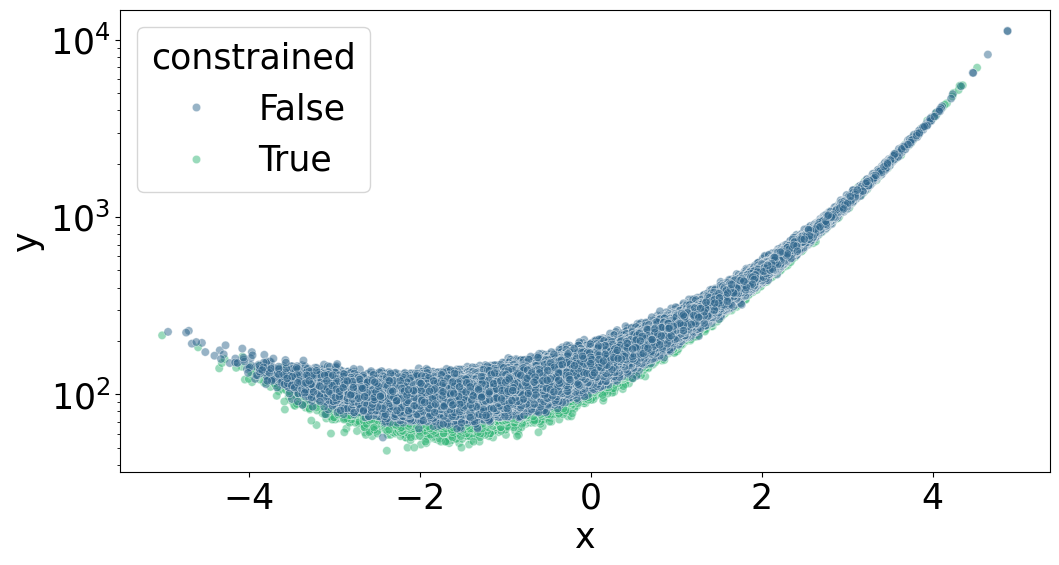

In [23]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.scatterplot(data=DATA, x='x', y='y', hue='constrained', palette='viridis', alpha=0.5)
plt.yscale('log')

In [ ]:
# TODO 
# rather than choosing positive examples uniformly at random, 
# as we did above, 
# choose them with a probability dependent on x (to mimic real scenarios, e.g, enhancers are enriched in GC content)

## Fit neutral models

In [24]:
import statsmodels.api as sm

# Mute SettingWithCopyWarning
pd.options.mode.chained_assignment = None

MODEL_TYPES = ['constant', 'linear', 'quadratic'] 

def fit_poisson_model(df, model_type):
    df_neg = df[df['constrained'] == False]

    if model_type == 'constant':
        x_model_neg = np.ones((df_neg.shape[0], 1))
        x_model = np.ones((df.shape[0], 1))  
    elif model_type == 'linear':
        x_model_neg = sm.add_constant(df_neg['x'])
        x_model = sm.add_constant(df['x'])
    elif model_type == 'quadratic':
        df_neg['x2'] = df_neg['x']**2
        x_model_neg = sm.add_constant(df_neg[['x', 'x2']])
        df['x2'] = df['x']**2
        x_model = sm.add_constant(df[['x', 'x2']])
    else:
        raise ValueError(f"Unknown model type: {model_type}")
            
    neutral_model = sm.Poisson(df_neg['y'], x_model_neg).fit(disp=False)

    print(f'{model_type} model of lambda:')
    estimated_params_keys = ['alpha', 'beta', 'gamma']
    estimated_params_values = neutral_model.params.values
    for i, estimated_param_value in enumerate(estimated_params_values):
        print(f'{estimated_params_keys[i]}: {estimated_param_value:.2f} ({TRUE_PARAMS_KEYS[i]}: {TRUE_PARAMS_VALUES[i]})')
    print()
    
    df[f'predicted_y_{model_type}Model'] = neutral_model.predict(x_model)

    df[f'residuals_{model_type}Model'] = df[f'predicted_y_{model_type}Model'] - df['y']
    df[f'standardized_residuals_{model_type}Model'] = df[f'residuals_{model_type}Model']/np.sqrt(df[f'predicted_y_{model_type}Model'])
        
    return df

def fit_poison_model_wrapper(df):
    for model_type in MODEL_TYPES:
        df = fit_poisson_model(df, model_type)
    return df

DATA = fit_poison_model_wrapper(DATA)
DATA

constant model of lambda:
alpha: 5.21 (A: 5)

linear model of lambda:
alpha: 5.09 (A: 5)
beta: 0.50 (B: 0.4)

quadratic model of lambda:
alpha: 5.00 (A: 5)
beta: 0.40 (B: 0.4)
gamma: 0.10 (C: 0.1)



,x,y,constrained,predicted_y_constantModel,residuals_constantModel,standardized_residuals_constantModel,predicted_y_linearModel,residuals_linearModel,standardized_residuals_linearModel,x2,predicted_y_quadraticModel,residuals_quadraticModel,standardized_residuals_quadraticModel
0,0.717529,206,True,183.248963,-22.751037,-1.680662,231.607618,25.607618,1.682646,0.514848,208.220457,2.220457,0.153879
1,-1.076697,96,True,183.248963,87.248963,6.445246,94.435461,-1.564539,-0.160997,1.159277,108.345729,12.345729,1.186071
2,0.687623,156,True,183.248963,27.248963,2.012933,228.170039,72.170039,4.777796,0.472825,204.881424,48.881424,3.415015
3,-0.103472,108,True,183.248963,75.248963,5.558783,153.628467,45.628467,3.681290,0.010707,142.559793,34.559793,2.894494
4,1.001992,254,True,183.248963,-70.751037,-5.226513,267.007929,13.007929,0.796061,1.003988,245.012219,-8.987781,-0.574194
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1.080741,280,False,183.248963,-96.751037,-7.147182,277.731124,-2.268876,-0.136144,1.168001,257.035075,-22.964925,-1.432415
999996,-0.511368,120,False,183.248963,63.248963,4.672321,125.284351,5.284351,0.472110,0.261497,124.173360,4.173360,0.374517
999997,0.916388,236,False,183.248963,-52.751037,-3.896819,255.820363,19.820363,1.239208,0.839766,232.907289,-3.092711,-0.202651
999998,1.175176,248,False,183.248963,-64.751037,-4.783282,291.159626,43.159626,2.529368,1.381038,272.678853,24.678853,1.494511


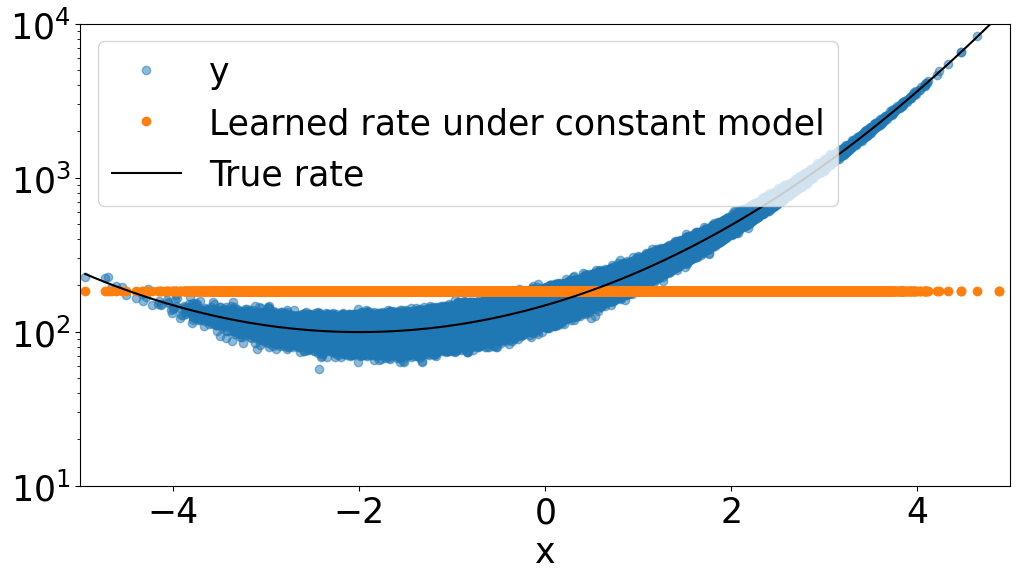

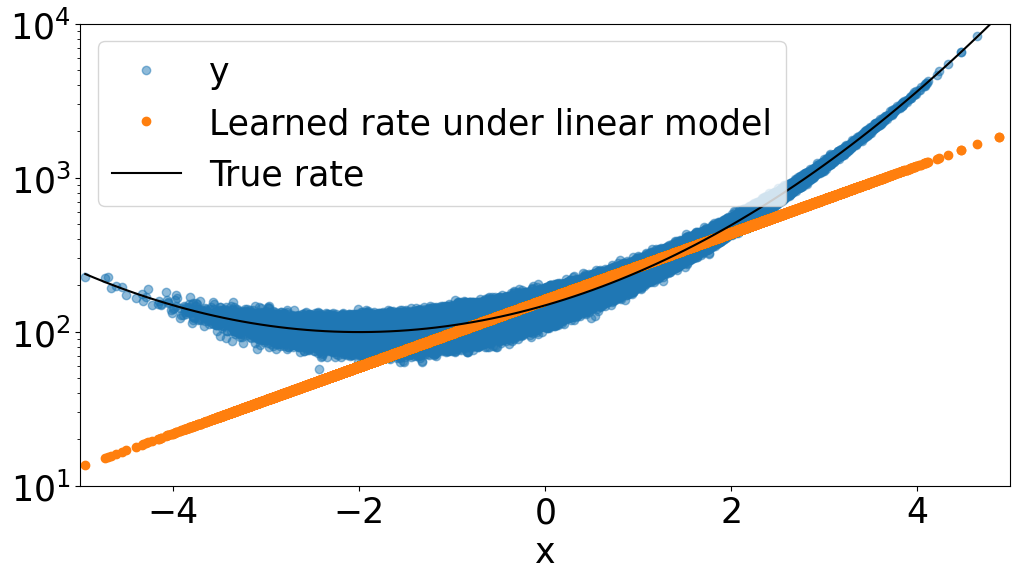

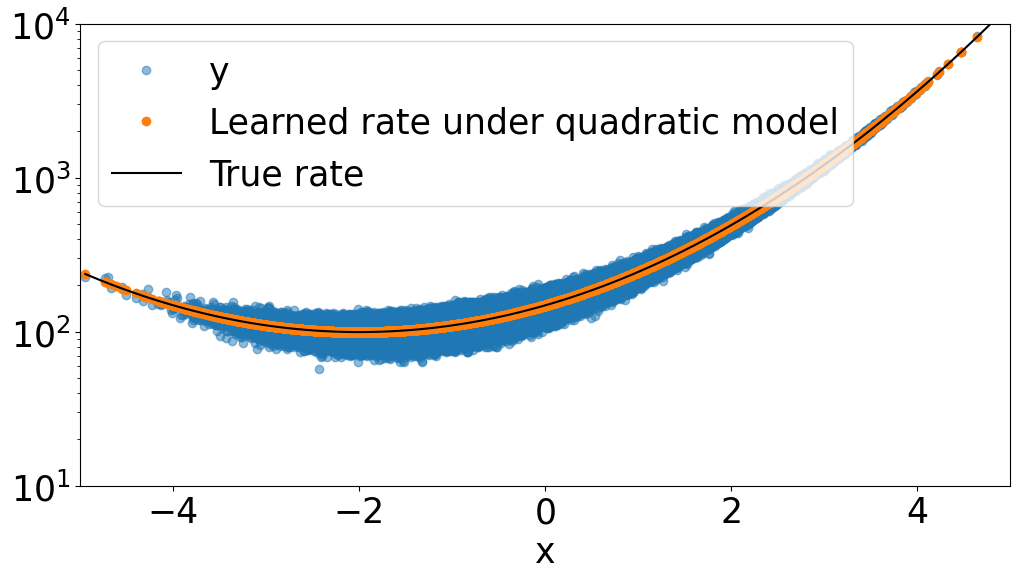

In [25]:
def plot_y(df, model_type, ylim):
    df = df[df['constrained'] == False]

    x_ = np.linspace(df['x'].min(), df['x'].max(), 100)
    y_ = TRUE_RATE(x_)

    plt.figure(figsize=(12, 6))
    plt.plot(df['x'], df['y'], 'o', alpha=0.5, label='y')
    plt.plot(df['x'], df[f'predicted_y_{model_type}Model'], 'o', label=f'Learned rate under {model_type} model')
    plt.plot(x_, y_, label='True rate', color='black')
    plt.yscale('log')
    plt.xlabel('x')
    plt.legend(prop={'size': 25})
    plt.xlim(-5, 5)
    plt.ylim(ylim)

plot_y(DATA, model_type='constant', ylim=(1e1, 1e4))
plot_y(DATA, model_type='linear', ylim=(1e1, 1e4))
plot_y(DATA, model_type='quadratic', ylim=(1e1, 1e4))

## Residuals are biased when models are misspecified 

/tmp/ipykernel_3002330/3599008281.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_residual = df.groupby('x_bin_midpoints')[residual_label].mean()
/tmp/ipykernel_3002330/3599008281.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_residual = df.groupby('x_bin_midpoints')[residual_label].mean()
/tmp/ipykernel_3002330/3599008281.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_residual = 

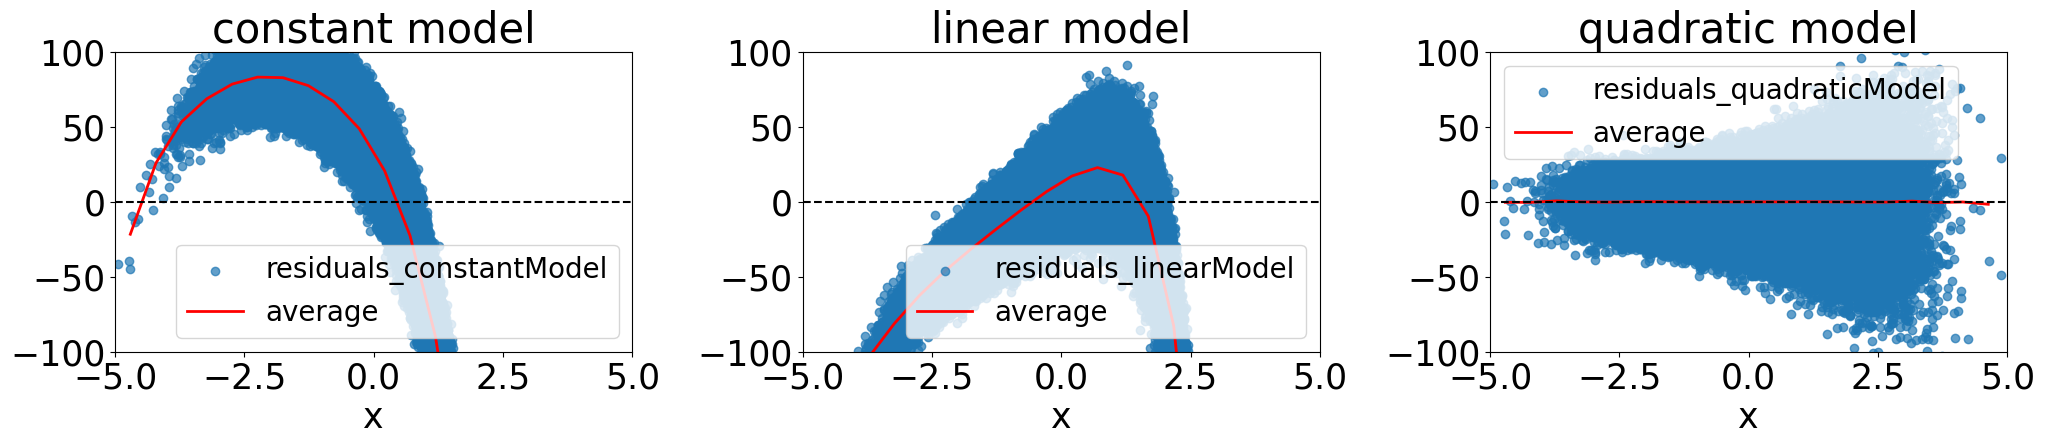

/tmp/ipykernel_3002330/3599008281.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_residual = df.groupby('x_bin_midpoints')[residual_label].mean()
/tmp/ipykernel_3002330/3599008281.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_residual = df.groupby('x_bin_midpoints')[residual_label].mean()
/tmp/ipykernel_3002330/3599008281.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_residual = 

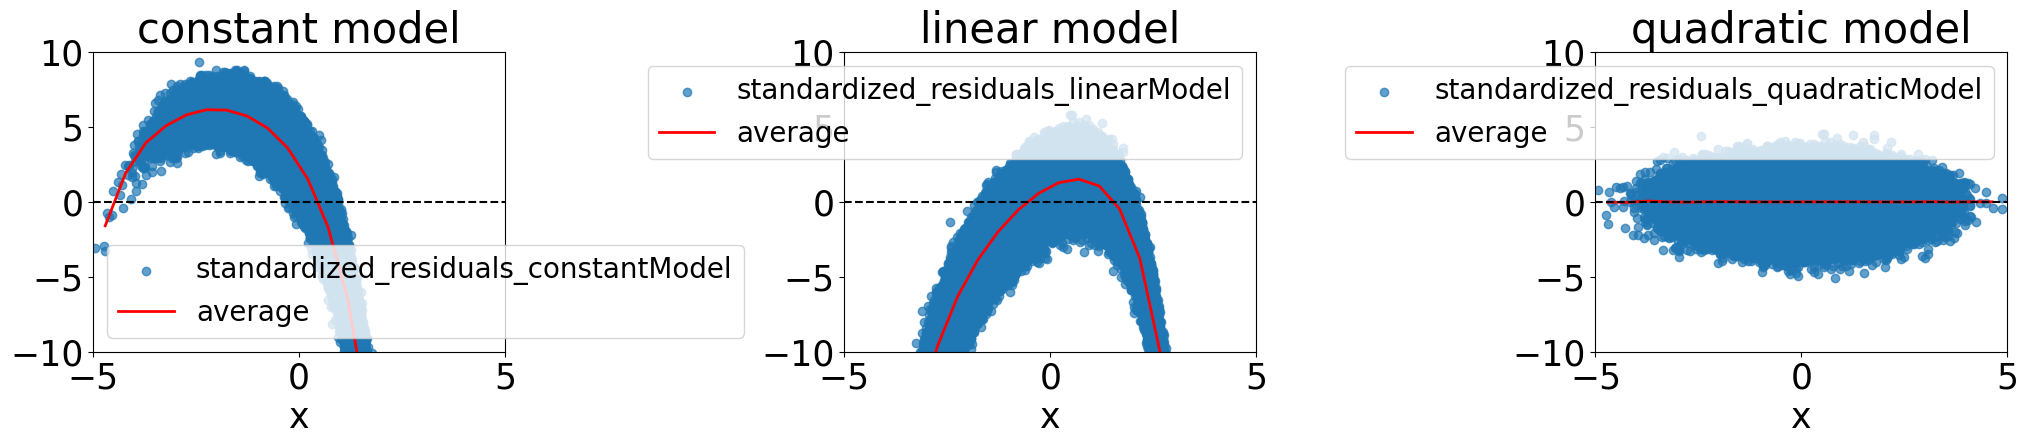

In [26]:
plt.rcParams.update({'font.size': 25})

def plot_residuals_vs_feature(ax, df, standardized, model_type):
    df = df[df['constrained'] == False]

    df['x_bin_midpoints'] = (pd
        .cut(df['x'], bins=20, labels=None)
        .apply(lambda x: (x.right + x.left) / 2)
    )

    residual_label = f'standardized_residuals_{model_type}Model' if standardized else f'residuals_{model_type}Model'    

    average_residual = df.groupby('x_bin_midpoints')[residual_label].mean()  

    ax.scatter(df['x'], df[residual_label], alpha=0.7, label=residual_label)
    ax.plot(average_residual.index, average_residual.values, color='red', lw=2, label=f'average') 
    ax.axhline(0, color='black', linestyle='--')

    ax.set_title(f'{model_type} model')
    ax.set_xlabel('x')
    ylim = (-10, 10) if standardized else (-100, 100) 
    ax.set_ylim(ylim)
    yticks = [-10, -5, 0, 5, 10] if standardized else [-100, -50, 0, 50, 100] 
    ax.set_yticks(yticks)
    ax.set_xlim(-5, 5)
    ax.legend(prop={'size': 20})

def plot_residuals_vs_feature_all_models(df, standardized): 
    fig, axes = plt.subplots(1, len(MODEL_TYPES), figsize=(7*len(MODEL_TYPES), 5))

    for i, model_type in enumerate(MODEL_TYPES):
        ax = axes[i]
        plot_residuals_vs_feature(
            ax, 
            df, 
            standardized, 
            model_type, 
        )

    plt.tight_layout()
    plt.show()

plot_residuals_vs_feature_all_models(DATA, standardized=False)
plot_residuals_vs_feature_all_models(DATA, standardized=True)

## Stratify neutral models' performances by x

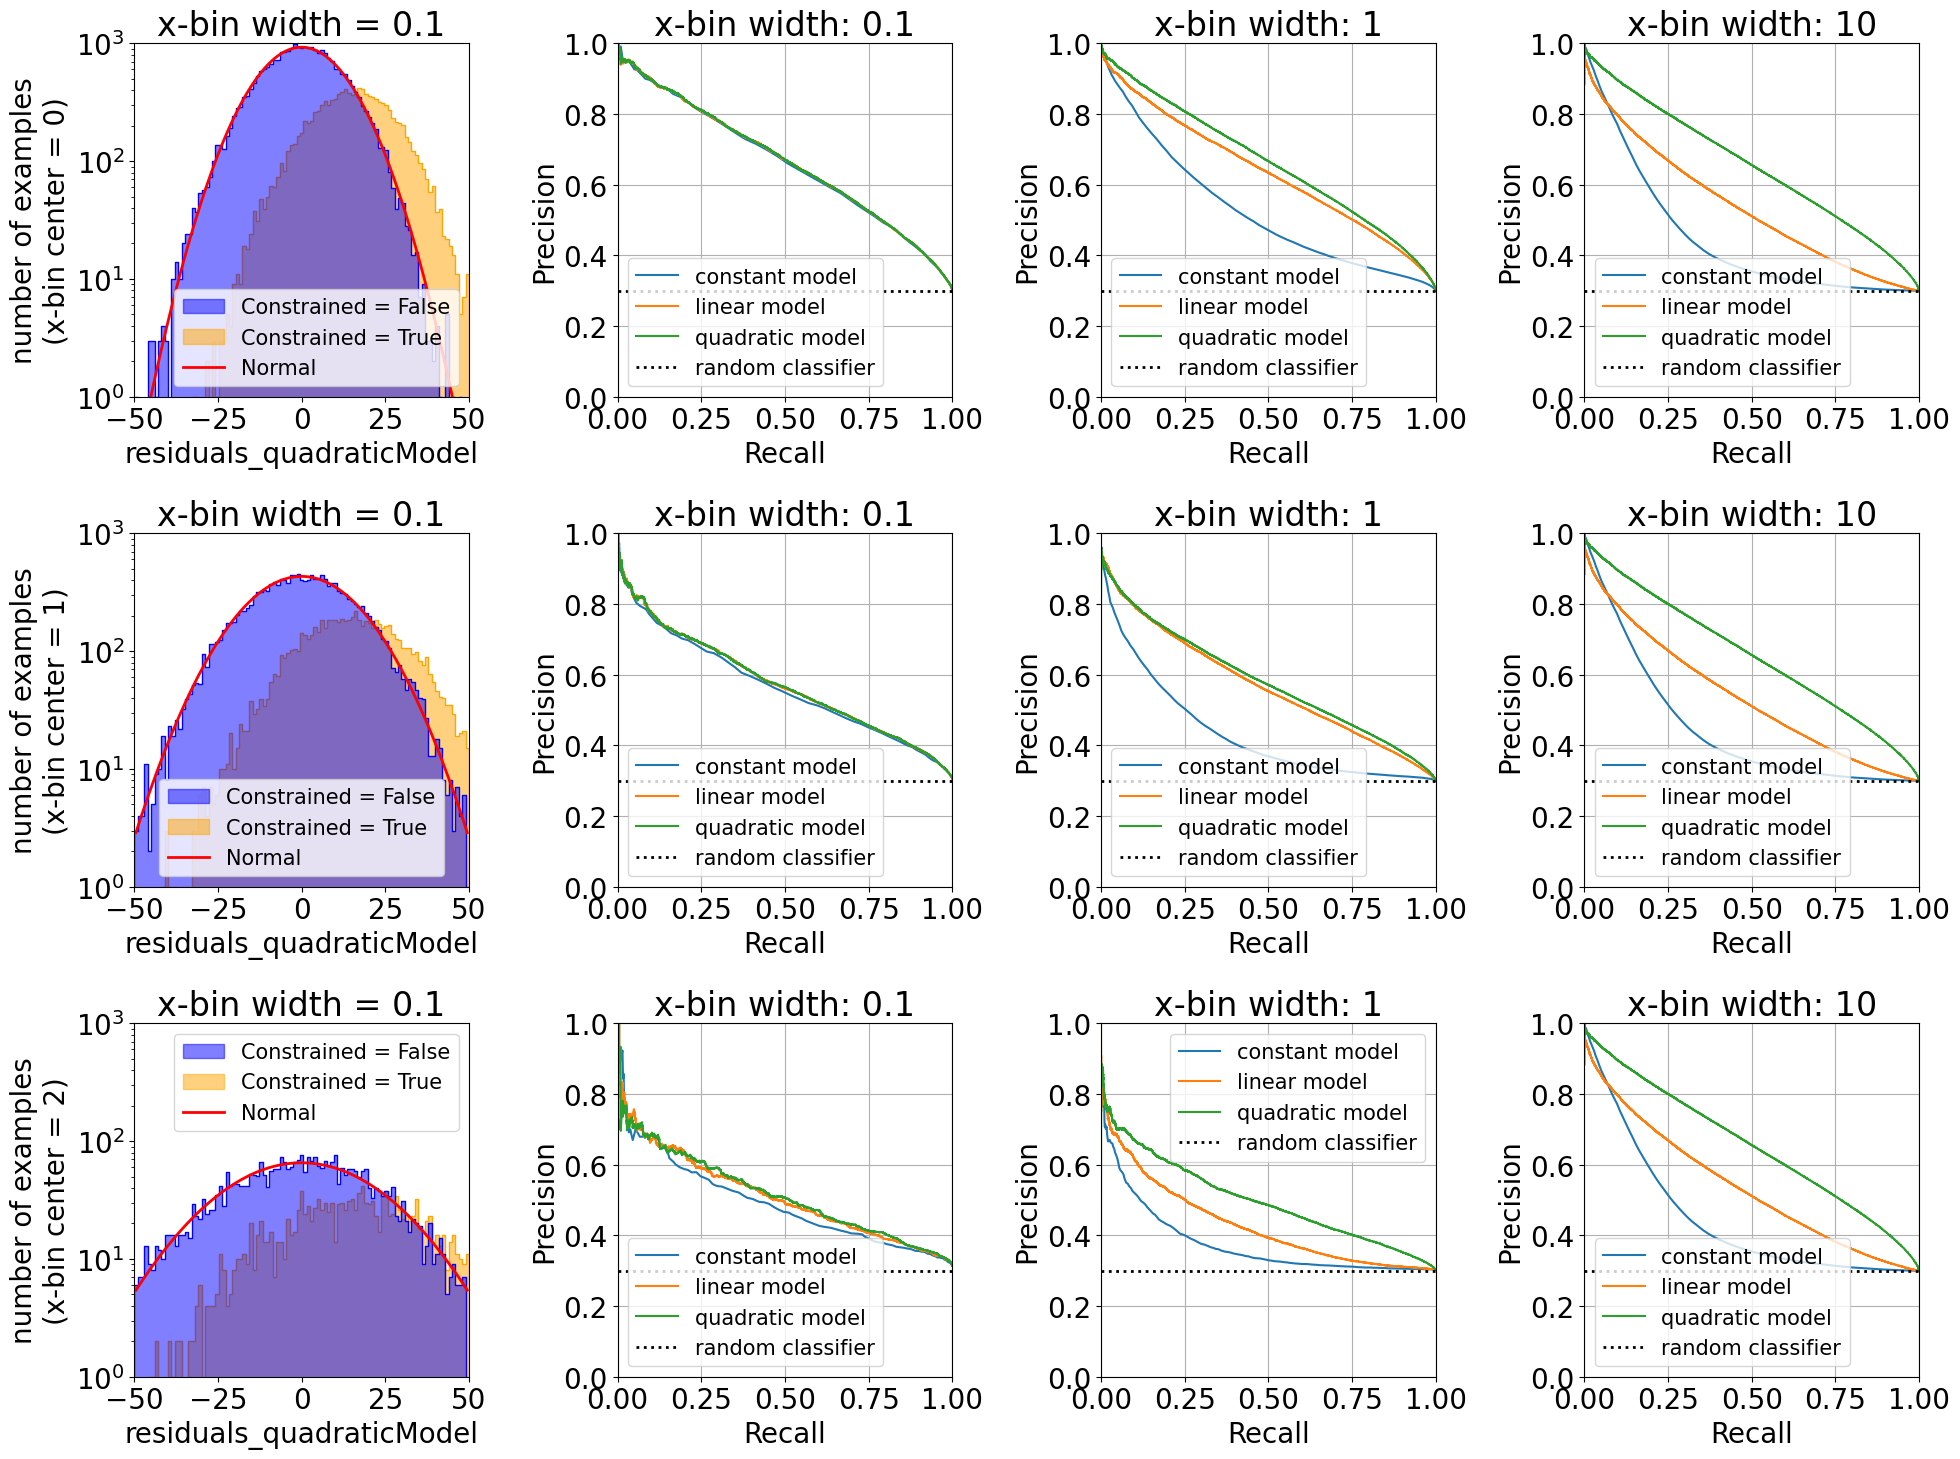

In [ ]:
from sklearn.metrics import precision_recall_curve
import seaborn as sns
from matplotlib.patches import Patch

plt.rcParams.update({'font.size': 20})

NUMBER_EXAMPLES_MIN = 100

def filter_by_bin(df, bin_center, bin_width):
    left = bin_center - bin_width / 2
    right = bin_center + bin_width / 2
    df = df[
        (df['x'] >= left) & 
        (df['x'] < right)
    ]
    return df 

def normal_distribution(x, mu, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def plot_residual_distributions(ax, df, standardized, xlim, model_type, title, ylabel, ylim):
    xlabel = f'standardized_residuals_{model_type}Model' if standardized else f'residuals_{model_type}Model'    

    bins = np.linspace(xlim[0], xlim[1], 100)         
    bin_centers = (bins[1:] + bins[:-1]) / 2
    bin_width = bins[1] - bins[0]

    palette = {False: 'blue', True: 'orange'}
    alpha = 0.5  

    sns.histplot(
        data=df, 
        x=xlabel, 
        hue='constrained', 
        kde=False, 
        element='step', 
        bins=bins, 
        ax=ax, 
        palette=palette, 
        alpha=alpha
    )

    # Plot normal distribution
    x = bin_centers
    if standardized:
        y = normal_distribution(x, mu=0, sigma=1)
    else:
        # assumes the x in df are in the vicinity of x0, 
        # so that the average y value of the negative examples is a good estimate of TRUE_RATE(x0)
        lambda_ = df[df['constrained'] == False]['y'].mean()

        y = normal_distribution(x, mu=0, sigma=np.sqrt(lambda_))            
    negative_class_count = len(df[df['constrained'] == False])
    y_scaled = y * negative_class_count * bin_width  
    normal_line, = ax.plot(x, y_scaled, color='red', lw=2)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_yscale('log')  
    ax.set_xlim(xlim) 
    ax.set_ylim(ylim)
    ax.set_title(title)

    # Manually create legend handles and labels
    handles = [
        Patch(color=palette[False], alpha=alpha),
        Patch(color=palette[True], alpha=alpha),
        normal_line
    ]
    labels = [
        'Constrained = False', 
        'Constrained = True', 
        'Standard Normal' if standardized else 'Normal'
    ]
    ax.legend(handles=handles, labels=labels, prop={'size': 15})

def plot_pr_curve(ax, df, model_type):
    # using standardized_residuals appear to yield larger auPRC than raw residuals
    # c.f., section entitled "Model bias is responsible for poor genome-wide performance" in this notebook
    precision, recall, _ = precision_recall_curve(df['constrained'], df[f'standardized_residuals_{model_type}Model'])
    num_examples = len(df)

    if num_examples > NUMBER_EXAMPLES_MIN:
        ax.plot(recall, precision, label=f'{model_type} model')

def plot_pr_curve_wrapper(df): 
    bin_centers = [0, 1, 2]

    bin_widths = [0.1, 1, 10]     
    # duplicate the first element so we can create two different plots for the smallest bin width:
    bin_widths.insert(0, bin_widths[0]) 
    
    fig, axes = plt.subplots(len(bin_centers), len(bin_widths), figsize=(5*len(bin_widths), 5*len(bin_centers)))

    for i, bin_center in enumerate(bin_centers):
        for j, bin_width in enumerate(bin_widths):
            df_filtered = filter_by_bin(df, bin_center, bin_width)
            ax = axes[i, j]
            if j == 0:
                plot_residual_distributions(
                    ax, 
                    df_filtered, 
                    standardized=False, 
                    xlim=(-50, 50), 
                    model_type='quadratic', 
                    title=f'x-bin width = {bin_width}', 
                    ylabel=(
                        'number of examples\n'
                        f'(x-bin center = {bin_center})'
                    ), 
                    ylim=(1, 1e3)
                )
            else: 
                for model_type in MODEL_TYPES:                
                    plot_pr_curve(ax, df_filtered, model_type)
                ax.plot([0, 1], [POSITIVE_FRACTION, POSITIVE_FRACTION], color='black', lw=2, linestyle=':', label='random classifier')
                ax.set_xlabel('Recall')
                ax.set_ylabel('Precision')
                ax.set_title(f'x-bin width: {bin_width}')
                ax.legend(prop={'size': 15})  
                ax.set_xlim(0, 1)
                ax.set_ylim(0, 1)
                ax.grid(True)
                
    plt.tight_layout()
    plt.show()

plot_pr_curve_wrapper(DATA)

## Model bias is responsible for poor genome-wide performance 

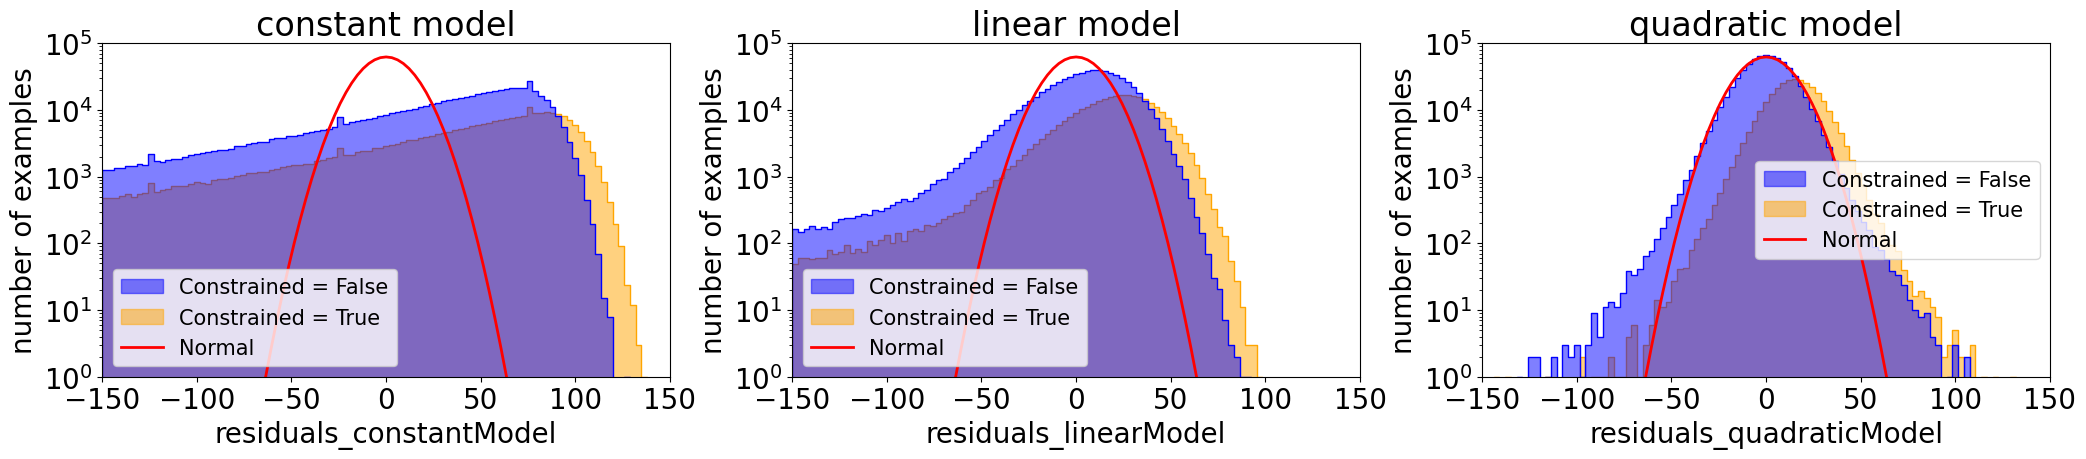

In [44]:
def plot_residual_distributions_all_models(df, standardized, xlim): 
    fig, axes = plt.subplots(1, len(MODEL_TYPES), figsize=(7*len(MODEL_TYPES), 5))

    for i, model_type in enumerate(MODEL_TYPES):
        ax = axes[i]
        plot_residual_distributions(
            ax, 
            df, 
            standardized=standardized, 
            xlim=xlim, 
            model_type=model_type, 
            title=f'{model_type} model', 
            ylabel='number of examples', 
            ylim=(1, 1e5)
        )

    plt.tight_layout()
    plt.show()

plot_residual_distributions_all_models(DATA, standardized=False, xlim=(-150, 150))

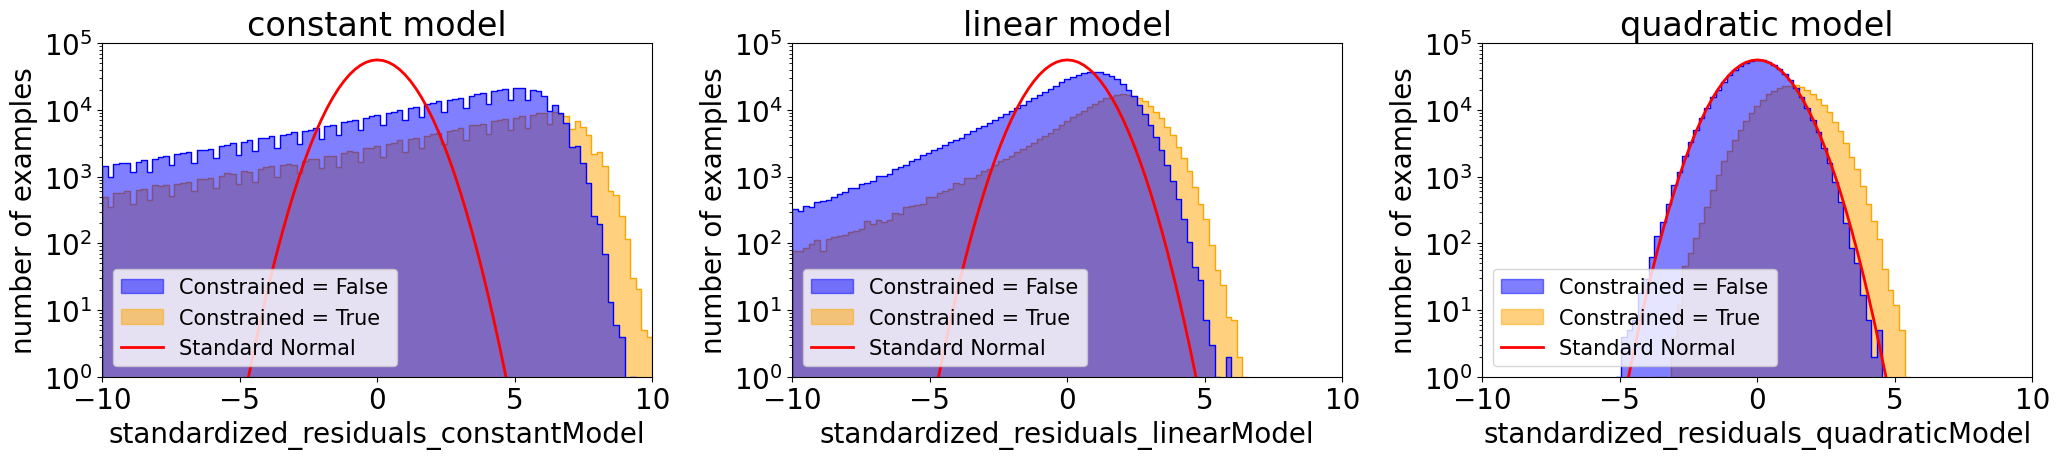

In [45]:
plot_residual_distributions_all_models(DATA, standardized=True, xlim=(-10, 10))

## How observed and expected SNV counts depend on standardized residuals

In [ ]:
# TODO continue from here ... Mon 11/25/24 

# do simulation to mimic the experimental result that expected y goes up with gnocchi, but not observed y 

# Add this image to this notebook: 
# https://docs.google.com/presentation/d/1QyoCJSHlWG4FqyFuJ-mO7U-R0cqsIq5GhYjReAO1s60/edit#slide=id.g2257848117b_0_175
#


In [65]:
quantiles = np.linspace(0, 1, 51)
quantiles
quantile_bins = DATA['standardized_residuals_quadraticModel'].quantile(quantiles).unique()
quantile_bins
# Bin the data by standardized_residuals_quadraticModel using quantile bins
DATA['binned'] = pd.cut(DATA['standardized_residuals_quadraticModel'], bins=quantile_bins, include_lowest=True)
DATA


,x,y,constrained,predicted_y_constantModel,residuals_constantModel,standardized_residuals_constantModel,predicted_y_linearModel,residuals_linearModel,standardized_residuals_linearModel,x2,predicted_y_quadraticModel,residuals_quadraticModel,standardized_residuals_quadraticModel,binned
0,0.717529,206,True,183.248963,-22.751037,-1.680662,231.607618,25.607618,1.682646,0.514848,208.220457,2.220457,0.153879,"(0.108, 0.166]"
1,-1.076697,96,True,183.248963,87.248963,6.445246,94.435461,-1.564539,-0.160997,1.159277,108.345729,12.345729,1.186071,"(1.164, 1.244]"
2,0.687623,156,True,183.248963,27.248963,2.012933,228.170039,72.170039,4.777796,0.472825,204.881424,48.881424,3.415015,"(2.752, 5.427]"
3,-0.103472,108,True,183.248963,75.248963,5.558783,153.628467,45.628467,3.681290,0.010707,142.559793,34.559793,2.894494,"(2.752, 5.427]"
4,1.001992,254,True,183.248963,-70.751037,-5.226513,267.007929,13.007929,0.796061,1.003988,245.012219,-8.987781,-0.574194,"(-0.61, -0.533]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1.080741,280,False,183.248963,-96.751037,-7.147182,277.731124,-2.268876,-0.136144,1.168001,257.035075,-22.964925,-1.432415,"(-1.614, -1.4]"
999996,-0.511368,120,False,183.248963,63.248963,4.672321,125.284351,5.284351,0.472110,0.261497,124.173360,4.173360,0.374517,"(0.34, 0.397]"
999997,0.916388,236,False,183.248963,-52.751037,-3.896819,255.820363,19.820363,1.239208,0.839766,232.907289,-3.092711,-0.202651,"(-0.256, -0.193]"
999998,1.175176,248,False,183.248963,-64.751037,-4.783282,291.159626,43.159626,2.529368,1.381038,272.678853,24.678853,1.494511,"(1.413, 1.507]"


/tmp/ipykernel_3002330/4057543928.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_means_predicted = DATA.groupby('binned')['predicted_y_quadraticModel'].mean()
/tmp/ipykernel_3002330/4057543928.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_means_y = DATA.groupby('binned')['y'].mean()


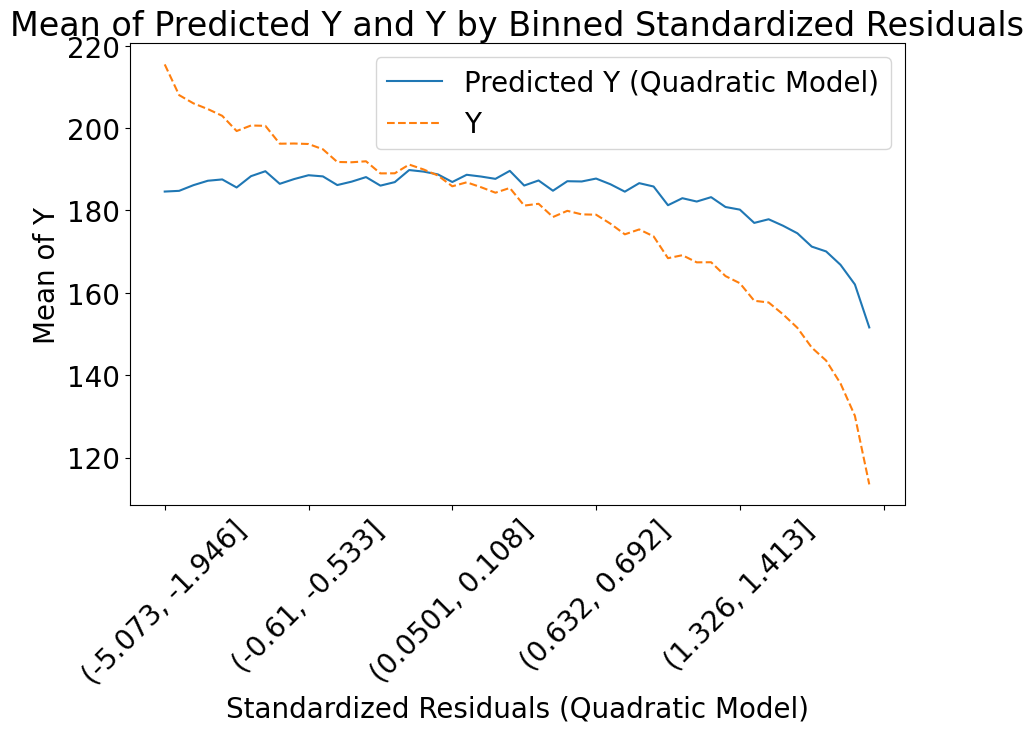

In [ ]:

# Compute the mean of predicted_y_quadraticModel and y for each bin
binned_means_predicted = DATA.groupby('binned')['predicted_y_quadraticModel'].mean()
binned_means_y = DATA.groupby('binned')['y'].mean()

# Plot the result
plt.figure(figsize=(10, 6))
binned_means_predicted.plot(kind='line', label='Predicted Y (Quadratic Model)')
binned_means_y.plot(kind='line', label='Y', linestyle='--')
plt.xlabel('Standardized Residuals (Quadratic Model)')
plt.ylabel('Mean of Y')
plt.title('Mean of Predicted Y and Y by Binned Standardized Residuals')
plt.legend()
plt.xticks(rotation=45)
plt.show()